In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib as plt
%matplotlib inline

/home/susanna/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


## step one: data

### creating data 1.1: generating values with numpy

In [2]:
# create a large dataset: one million points

X_data = np.linspace(0.0,10.0,1000000)

In [3]:
# create some noise
# pass in the number of points needed: same as X_data

noise = np.random.randn(len(X_data))

In [4]:
# check to see: these are just a million data points each
# linear distribution for X_data
# random numbers from noise

print(X_data, '\n', 'shape: ', X_data.shape)
print('\n')
print(noise, '\n', 'shape: ', noise.shape)

[0.000000e+00 1.000001e-05 2.000002e-05 ... 9.999980e+00 9.999990e+00
 1.000000e+01] 
 shape:  (1000000,)


[ 0.37538724  0.24850549 -0.96602169 ... -0.11922718 -0.41802665
 -1.13637928] 
 shape:  (1000000,)


remember, we're modeling a line with the shape 

y = mx + b

let's set 

b = 5

and

m = 0.5

now generate this line (and add in the noise we created earlier):

In [5]:
# b from y = mx + b

intercept = 5

# m from y = mx + b

slope = 0.5

# y = mx + b (and a little noise)

y_actual = slope * X_data + intercept + noise

### creating data 1.2: visualization using pandas dataframes

creating dataframes using pandas:

In [6]:
# create a dataframe for X

X_dataframe = pd.DataFrame(data=X_data, columns=['X'])

X_dataframe.head()

,X
0,0.00000
1,0.00001
2,0.00002
3,0.00003
4,0.00004


In [7]:
# create a dataframe for y

y_dataframe = pd.DataFrame(data=y_actual, columns=['y'])

y_dataframe.head()

,y
0,5.375387
1,5.248510
2,4.033988
3,6.035138
4,5.794618


merge (concatenate) the 2 dataframes together using pandas .concat() method:

In [8]:
# pass in dataframes to merge as a list
# add an axis to merge along columns vs rows
# axis=1 merges along columns

df = pd.concat([X_dataframe, y_dataframe], axis=1)

df.head()

,X,y
0,0.00000,5.375387
1,0.00001,5.248510
2,0.00002,4.033988
3,0.00003,6.035138
4,0.00004,5.794618


### visualizing the data

with 1 million data points, it would be difficult (if not impossible) to plot here in jupyter notebook (without crashing the kernel). using pandas, we can take a sample of any size we specify and plot that:

In [9]:
# grab a sample
# this one has 250 points

df_sample = df.sample(n=250)

df_sample.head()

,X,y
153362,1.533622,6.238294
455825,4.558255,7.994337
910195,9.101959,8.783467
419189,4.191894,6.900420
838067,8.380678,7.892872


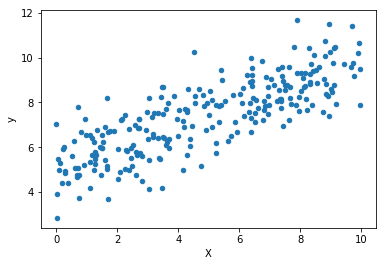

In [10]:
# now plot from the sample
# note: scatterplots require args for x and y

df_sample.plot(kind='scatter', x='X', y='y')

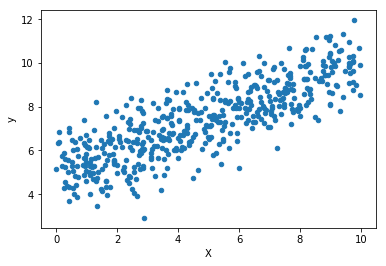

In [11]:
# this can all be done in 1 line, too
# here's a sample plot with 500 points

df.sample(n=500).plot(kind='scatter', x='X', y='y')

the plot with 500 sample points is a little more dense than the plot with 250.

we can also see there is definitely a linear fit (albeit with a little noise), a positive (upward) slope, and that the intercept is around 5, as we set before adding in the noise.

## step two: creating a model

#### overview of the process:
#### 1) create variables
#### 2) create placeholders
#### 3) build the graph


### a note on batch size

a million data points is too many to pass in all at once! complex models work best when they have a lot of data. the solution: feeding data in in batches.

what size should batches be? that depends on the data. smaller datasets don't really need batches; training a model on a large dataset with tiny batches could take a while. for this model, i'll be using a batch size of 50.

In [23]:
training_batch_size = 8

### setting up variables

remember: y = mx + b

setting up variables for the slope (m) & intercept (b) in our model:

In [24]:
# initialize with random numbers

m = tf.Variable(np.random.rand())

#m = tf.Variable(0.32)

b = tf.Variable(np.random.rand())

#b = tf.Variable(1.26)

### placeholders for data feeds

creating placeholders for the data to feed into the model. note: we need placeholders for both X and y, and the size will be the same as a training_batch_size:

In [25]:
# placeholder size is the same as the training batch

X_datafeed = tf.placeholder(tf.float32,[training_batch_size])

y_datafeed = tf.placeholder(tf.float32,[training_batch_size])

### building the graph (model)

In [26]:
# y = mx + b yet again
# this time we're directly feeding the data into the model

model = m * X_datafeed + b

# that's it!

### cost/loss function

In [27]:
# error squared
# squares the difference between the true data and the model
# use tensorflow functionality to make this neatly on one line

error_sqd = tf.reduce_sum(tf.square(y_datafeed - model))

### optimizer

In [28]:
# initialize the optimizer object
# we'll use gradient descent for this one

GD_optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.001)

# set it to minimize the error we defined earlier

training = GD_optimizer.minimize(error_sqd)

### initialize variables and run the training

set up an object to initialize variables:

In [29]:
initializer = tf.global_variables_initializer()

#### another note on batches:

this dataset has a strong linear trend that we can see, so it's unlikely that we'd need all 1 million samples for our model to find it. in fact, we could end up overfitting with that many samples on such a simple model. this where the number of batches selested to train on becomes important: both batch size and number of batches are two areas where there's room for experimentation. in this case, i'm pretty sure that my model can find a trend in < 1 million samples, so i'm setting the number of training batches to 500, which will give me 25,000 batches overall. 

this is likely too many for this model. but it should work for demonstration puposes (recall that all this data is effectively made-up), and larger batch sizes are fairly common with large datasets feeding into complex models.

In [30]:
with tf.Session() as sess:
    
    sess.run(initializer)
    
    # the number of 50-sample batch sizes we'll run through
    
    num_batches = 1000
    
    for i in range(num_batches):
        
        random_index = np.random.randint(len(X_data), size=training_batch_size)
        
        # create a feed dictionary
        
        my_feed_dict = {X_datafeed: X_data[random_index], y_datafeed: y_actual[random_index]}
        
        sess.run(training, feed_dict=my_feed_dict)
    
    # assign the results to python variables so we can see them
    
    m_model, b_model = sess.run([m,b])
          

In [31]:
m_model

0.53075606

In [32]:
b_model

4.934928